In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy(aja004@gmail.com)                               #
# 2017 Ji Yang(jyang7@ualberta.ca)                                    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import *

plt.rcParams['figure.figsize'] = [9, 6]

In [2]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

# gamma
DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UP_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_backup = dict()

def poisson(n, lam):
    global poisson_backup
    key = n * 10 + lam
    if key not in poisson_backup.keys():
        poisson_backup[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poisson_backup[key]

In [3]:
# current policy
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# current state value
state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# all possible states
states = []

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

In [4]:
# axes for printing use
axis_x_print = []
axis_y_print = []
for i in range(0, MAX_CARS + 1):
    for j in range(0, MAX_CARS + 1):
        axis_x_print.append(i)
        axis_y_print.append(j)
        states.append([i, j])

# plot a policy/state value matrix
figure_idx = 0


def pretty_print(data, labels, index=None):
    global figure_idx
    fig = plt.figure(figure_idx)
    figure_idx += 1
    ax = fig.add_subplot(111, projection='3d')
    if index:
        ax.title.set_text('π_{}'.format(index))
    axis_z = []
    for i, j in states:
        axis_z.append(data[i, j])
    ax.scatter(axis_x_print, axis_y_print, axis_z)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

In [5]:
def expected_return(state, action, state_value):
    """
    :param state: [# of cars in first location, # of cars in second location]
    :param action: positive if moving cars from first location to second location, negative if moving cars from second location to first location
    :param state_value: state value lookup matrix
    :return: expected return
    """
    # initialize the total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # go through all possible rental requests
    for rent_req_first_loc in range(0, POISSON_UP_BOUND):
        for rent_req_second_loc in range(0, POISSON_UP_BOUND):
            # moving cars
            num_car_first_loc = int(min(state[0] - action, MAX_CARS))
            num_car_second_loc = int(min(state[1] + action, MAX_CARS))

            # valid # of rental requests should be less than actual # of cars
            real_rental_first_loc = min(num_car_first_loc, rent_req_first_loc)
            real_rental_second_loc = min(num_car_second_loc, rent_req_second_loc)

            # get credits for renting
            reward = (real_rental_first_loc + real_rental_second_loc) * RENTAL_CREDIT
            num_car_first_loc -= real_rental_first_loc
            num_car_second_loc -= real_rental_second_loc

            # probability for current combination of rental requests
            prob = poisson(rent_req_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                   poisson(rent_req_second_loc, RENTAL_REQUEST_SECOND_LOC)

            # if set True, model is simplified such that the # of cars returned in daytime becomes
            # constant rather than a random value from poisson distribution, which will reduce
            # calculation time and leave the optimal policy/value state matrix almost the same
            constant_returned_car = True
            if constant_returned_car:
                # get returned cars, those cars can be used for renting tomorrow
                returned_car_first_loc = RETURNS_FIRST_LOC
                returned_car_second_loc = RETURNS_SECOND_LOC
                num_car_first_loc = min(num_car_first_loc + returned_car_first_loc, MAX_CARS)
                num_car_second_loc = min(num_car_second_loc + returned_car_second_loc, MAX_CARS)

                returns += prob * (
                    reward + DISCOUNT * state_value[num_car_first_loc, num_car_second_loc])
            else:
                num_car_first_loc_ = num_car_first_loc
                num_car_second_loc_ = num_car_second_loc
                prob_ = prob
                for returned_car_first_loc in range(0, POISSON_UP_BOUND):
                    for returned_car_second_loc in range(0, POISSON_UP_BOUND):
                        num_car_first_loc = num_car_first_loc_
                        num_car_second_loc = num_car_second_loc_
                        prob = prob_
                        num_car_first_loc = min(num_car_first_loc + returned_car_first_loc,
                                                MAX_CARS)
                        num_car_second_loc = min(num_car_second_loc + returned_car_second_loc,
                                                 MAX_CARS)
                        prob = poisson(returned_car_first_loc, RETURNS_FIRST_LOC) * \
                               poisson(returned_car_second_loc, RETURNS_SECOND_LOC) * prob
                        returns += prob * (
                            reward + DISCOUNT * state_value[num_car_first_loc, num_car_second_loc])
    return returns

In [6]:
new_state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
improve_policy = False
policy_idx = 0

while True:
    if improve_policy == True:
        # start policy improvement
        if policy_idx in [0, 1, 2, 3, 4]:
            pretty_print(policy,
                         ['# of cars at first location',
                          '# of cars at second location',
                          '# of cars to move during night'],
                         index=policy_idx)

        print('Policy improvement', policy_idx)
        policy_idx += 1
        new_policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        for i, j in states:
            action_returns = []
            # go through all actions and select the best one
            for action in actions:
                if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                    action_returns.append(expected_return([i, j], action, state_value))
                else:
                    action_returns.append(-float('inf'))
            best_action = np.argmax(action_returns)
            new_policy[i, j] = actions[best_action]

        # if policy is stable
        policy_changed = np.sum(new_policy != policy)
        print('Policy for', policy_changed, 'states changed')
        if policy_changed == 0:
            policy = new_policy
            print('Policy is stable now. End.')
            break
        policy = new_policy
        improve_policy = False

    # start policy evaluation
    for i, j in states:
        new_state_value[i, j] = expected_return([i, j], policy[i, j], state_value)

    if np.sum(np.abs(new_state_value - state_value)) < 1e-4:
        state_value[:] = new_state_value
        improve_policy = True
        continue
    state_value[:] = new_state_value

Policy improvement 0
Policy for 332 states changed
Policy improvement 1
Policy for 286 states changed
Policy improvement 2
Policy for 83 states changed
Policy improvement 3
Policy for 19 states changed
Policy improvement 4
Policy for 0 states changed
Policy is stable now. End.


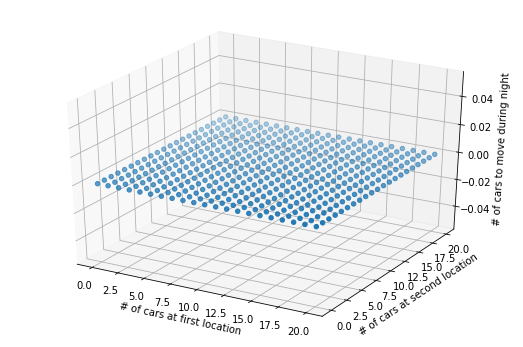

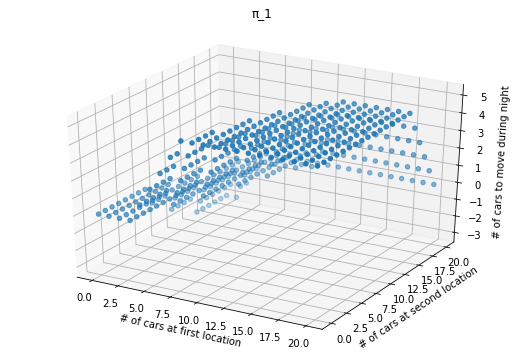

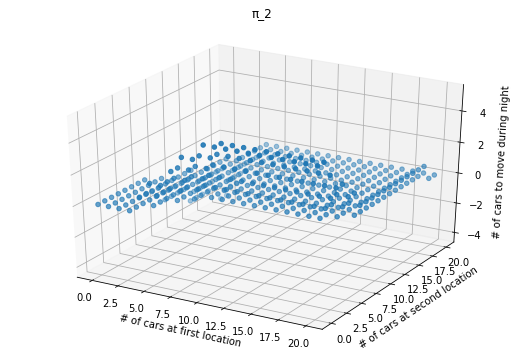

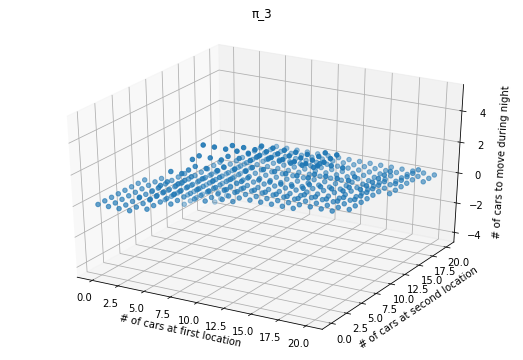

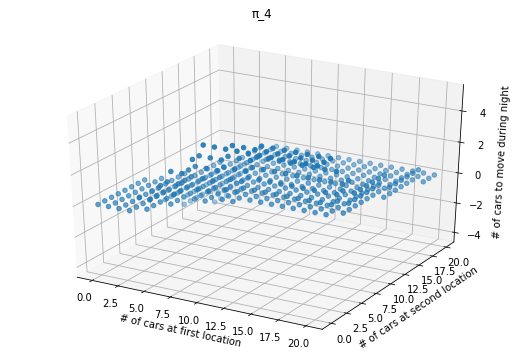

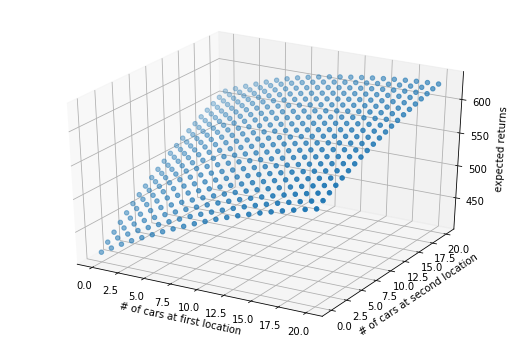

In [7]:
pretty_print(state_value,
             ['# of cars at first location',
              '# of cars at second location',
              'expected returns'])
plt.show()